In [8]:
from src.lightning_bg.evaluate import Evaluator, ShowTraj
from src.lightning_bg.architectures import get_network_by_name, BaseHParams
from src.lightning_bg.utils import dataset_setter
import os
import bgmol
from bgmol.systems.peptide import peptide
import yaml
import mdtraj

In [2]:
data_path = "./data"
param_path = "./params"
molecule = "/OppA/Peptides/1b4z/" # change this for different molecule 
experiment_name = "RNVPfwkl20000.yaml" # change this for different experiment
version = 0 # change this for different version

In [3]:
molecule_path = os.path.join(data_path, "Molecules", molecule.lstrip("/"))
molecule_path

'./data/Molecules/OppA/Peptides/1b4z/'

In [4]:
if "Dialanine" in "molecule":
    is_data_here = os.path.exists(molecule_path + "/Ala2TSF300.npy")
    ala_data = bgmol.datasets.Ala2TSF300(download=not is_data_here, read=True, root=molecule_path)
    system = ala_data.system
else:
    with open(molecule_path.rstrip("/") + "/top.pdb", 'r') as file:
        lines = file.readlines()
        lastline = lines[-3]
        n_atoms = int(lastline[4:11].strip())
        n_res = int(lastline[22:26].strip())
        print(n_atoms, n_res)

    # define system & energy model
    system = peptide(short=False, n_atoms=n_atoms, n_res=n_res, filepath=molecule_path)

59 3


In [9]:
experiment_path = os.path.join(param_path, molecule.lstrip("/"), experiment_name)
with open(experiment_path) as f:  # TODO: this is stupid bc there is a hparams file in the version folder. use it instead!!
    params = yaml.load(f, yaml.FullLoader)  # load the parameters
ModelClass = get_network_by_name(params['network_name'])
ParamClass = BaseHParams
params['network_params']['n_dims'] = n_atoms * 3
hparams = ParamClass(**params['network_params'])
checkpoint = os.path.join(data_path, "lightning_logs", molecule.lstrip("/"), experiment_name[:-5], f"version_{version}", "checkpoints/last.ckpt")
# checkpoint = "/home/kortkamp/helix/code/lightning_bg/data/lightning_logs/OppA/Peptides/1b4z/params/OppA/1b4z/RNVPfwkl20000/version_0/checkpoints/last.ckpt"

traj = mdtraj.load_hdf5(molecule_path + "/traj.h5")
coordinates = traj.xyz
train_split = params['training_params']['train_split']
train_data, val_data, test_data = dataset_setter(coordinates, system, val_split=(.8 - train_split), test_split=.2, seed=42)

model = ModelClass.load_from_checkpoint(checkpoint, hparams=hparams, train_data=train_data, val_data=val_data)

/home/kortkamp/mambaforge/envs/lightning_bg/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [13]:
x = model.generate_samples((100,))
w = ShowTraj(x, system)

In [14]:
w

ShowTraj(children=(NGLWidget(max_frame=99), BoundedFloatText(value=3611.93, description='Energy:', max=1e+50, …

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Energy [$k_B T$]', ylabel='# samples'>)

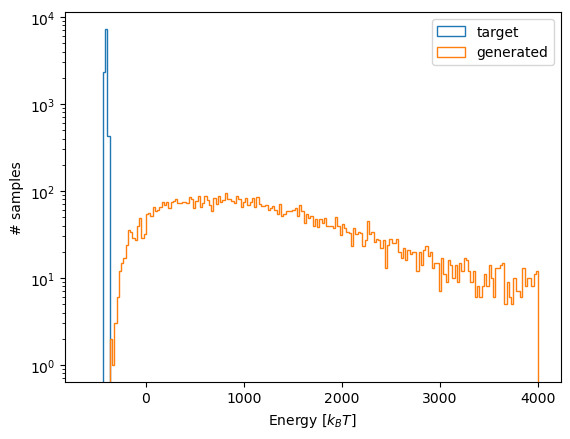

In [19]:
E = Evaluator(model, system)
E.energy_plot(rg=[-600, 4000])